In [3]:
!pip install chardet

LogisticRegression Test AUC: 0.7832
GradientBoosting Test AUC: 0.8076
RandomForest Test AUC: 0.7916
ExtraTrees Test AUC: 0.7809
XGBoost Test AUC: 0.7975

Best model: GradientBoosting (AUC=0.8076)


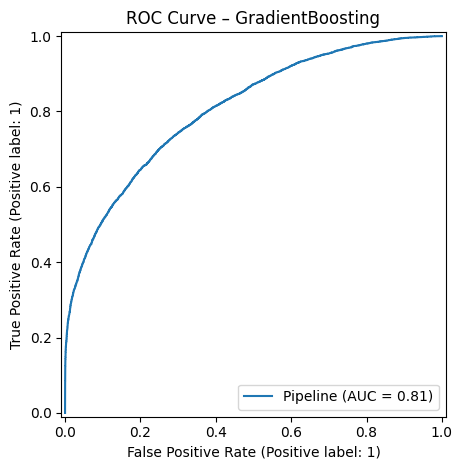

In [7]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, warnings
from pathlib import Path
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, RocCurveDisplay

# Base models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier

warnings.filterwarnings("ignore")

DATA_DIR = Path("./data2")
train_path = DATA_DIR/"train.csv"
test_path  = DATA_DIR/"test.csv"

def read_auto(p):
    encodings = ["utf-8", "euc-kr", "cp949", "utf-16"]
    for enc in encodings:
        try:
            return pd.read_csv(p, encoding=enc)
        except Exception:
            continue
    # fallback detect
    with open(p, 'rb') as f:
        raw = f.read(200000)
    enc = chardet.detect(raw)['encoding']
    return pd.read_csv(p, encoding=enc)

train = read_auto(train_path)
test  = read_auto(test_path)

# Date features
for df in (train, test):
    df["일시"] = pd.to_datetime(df["일시"], errors="coerce")
    df["hour"]  = df["일시"].dt.hour
    df["month"] = df["일시"].dt.month
    df["dow"]   = df["일시"].dt.dayofweek
    df.drop(columns=["일시"], inplace=True)

TARGET = "공기질"

# Remove rows without label
train = train.dropna(subset=[TARGET]).copy()
test  = test.dropna(subset=[TARGET]).copy()

y_train = train[TARGET].astype(int)
X_train = train.drop(columns=[TARGET])
y_test  = test[TARGET].astype(int)
X_test  = test.drop(columns=[TARGET])

# Identify categorical columns (object dtype or known category columns)
cat_cols = [c for c in X_train.columns if X_train[c].dtype == 'object']
# ensure category list includes known
for c in ["역명_호선","주중주말"]:
    if c in X_train.columns and c not in cat_cols:
        cat_cols.append(c)

num_cols = [c for c in X_train.columns if c not in cat_cols]

num_pipe = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
cat_pipe = make_pipeline(SimpleImputer(strategy="most_frequent"),
                         OneHotEncoder(handle_unknown="ignore"))

preproc = ColumnTransformer(
    [("num", num_pipe, num_cols),
     ("cat", cat_pipe, cat_cols)]
)

# models = {
#     "LogisticRegression": LogisticRegression(max_iter=1000, n_jobs=-1),
#     "GradientBoosting": GradientBoostingClassifier(random_state=42)
# }

# --------------------------------------------------------------------
# 4. Define models
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, n_jobs=-1),
    "GradientBoosting":   GradientBoostingClassifier(random_state=42),
    "RandomForest":       RandomForestClassifier(
                              n_estimators=400, max_depth=None,
                              n_jobs=-1, random_state=42),
    "ExtraTrees":         ExtraTreesClassifier(
                              n_estimators=400, random_state=42, n_jobs=-1)
}

# Try to import XGBoost
try:
    from xgboost import XGBClassifier
    models["XGBoost"] = XGBClassifier(
        n_estimators=600,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        n_jobs=-1
    )
except ImportError:
    print("XGBoost not installed; skipping.")


results = {}
for name, clf in models.items():
    pipe = Pipeline([("prep", preproc), ("clf", clf)])
    pipe.fit(X_train, y_train)
    prob = pipe.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, prob)
    results[name] = {"auc": auc, "pipe": pipe}
    print(f"{name} Test AUC: {auc:.4f}")

best_name = max(results, key=lambda k: results[k]["auc"])
best_auc = results[best_name]["auc"]
best_pipe = results[best_name]["pipe"]

print(f"\nBest model: {best_name} (AUC={best_auc:.4f})")

# ROC curve plot
RocCurveDisplay.from_estimator(best_pipe, X_test, y_test)
plt.title(f"ROC Curve – {best_name}")
plt.tight_layout()
plt.show()


LogReg  Test AUC: 0.7832
GBoost  Test AUC: 0.8076

► Best: GBoost  (AUC = 0.8076)


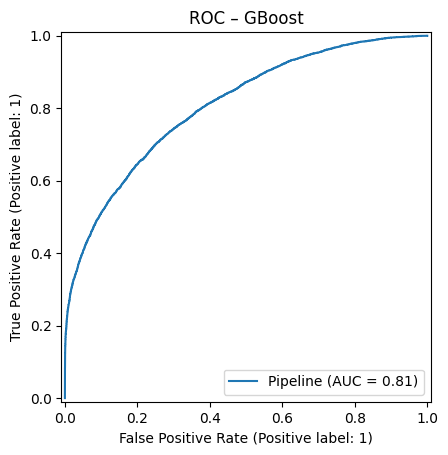

In [5]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, warnings
from pathlib import Path
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, RocCurveDisplay
warnings.filterwarnings("ignore")

# 1. CSV 경로
DATA_DIR = Path("./data2")          # Colab이면  Path("/content")
train = pd.read_csv(DATA_DIR/"train.csv", encoding="utf-8")
test  = pd.read_csv(DATA_DIR/"test.csv",  encoding="utf-8")

# 2. 날짜 파생
for df in (train, test):
    df["일시"]  = pd.to_datetime(df["일시"])
    df["hour"]  = df["일시"].dt.hour
    df["month"] = df["일시"].dt.month
    df["dow"]   = df["일시"].dt.dayofweek
    df.drop(columns=["일시"], inplace=True)

TARGET = "공기질"
train = train.dropna(subset=[TARGET])
test  = test .dropna(subset=[TARGET])

y_tr, X_tr = train[TARGET].astype(int), train.drop(columns=[TARGET])
y_te, X_te = test [TARGET].astype(int),  test .drop(columns=[TARGET])

cat_cols = [c for c in X_tr.columns if X_tr[c].dtype==object]
num_cols = [c for c in X_tr.columns if c not in cat_cols]
preproc  = ColumnTransformer([
    ("num", make_pipeline(SimpleImputer(strategy="median"), StandardScaler()), num_cols),
    ("cat", make_pipeline(SimpleImputer(strategy="most_frequent"),
                          OneHotEncoder(handle_unknown="ignore")), cat_cols)
])

models = {
    "LogReg" : LogisticRegression(max_iter=1000, n_jobs=-1),
    "GBoost" : GradientBoostingClassifier(random_state=42)
}

best_auc, best_name, best_pipe = -1, None, None
for name, clf in models.items():
    pipe = Pipeline([("prep", preproc), ("clf", clf)])
    pipe.fit(X_tr, y_tr)
    auc = roc_auc_score(y_te, pipe.predict_proba(X_te)[:,1])
    print(f"{name}  Test AUC: {auc:.4f}")
    if auc > best_auc:
        best_auc, best_name, best_pipe = auc, name, pipe

print(f"\n► Best: {best_name}  (AUC = {best_auc:.4f})")
RocCurveDisplay.from_estimator(best_pipe, X_te, y_te)
plt.title(f"ROC – {best_name}")
plt.show()
